In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt

# RECTIFICACION

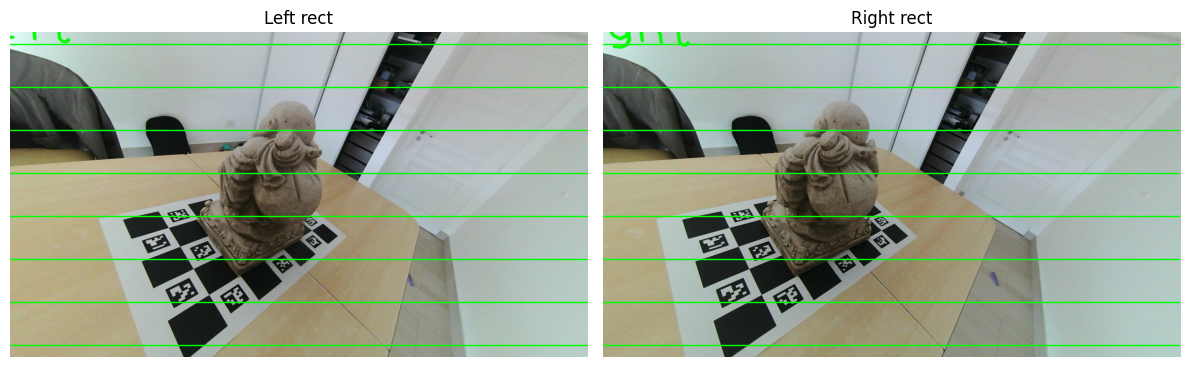

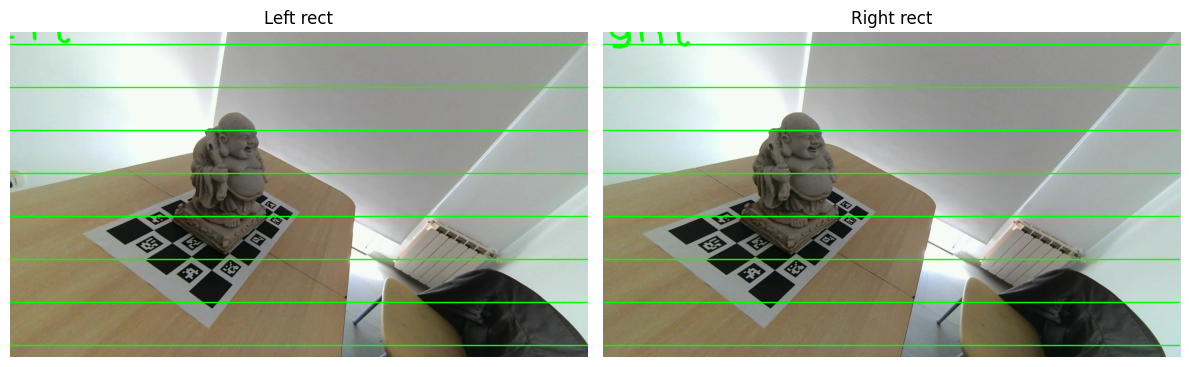

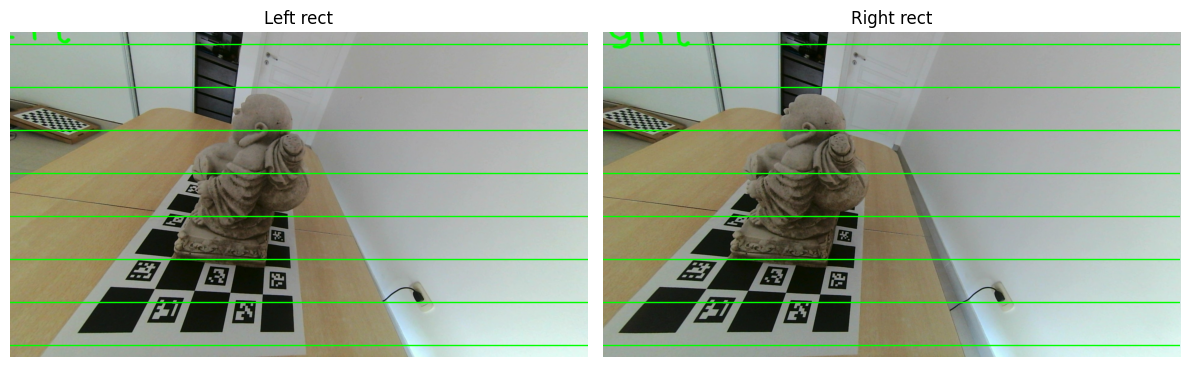

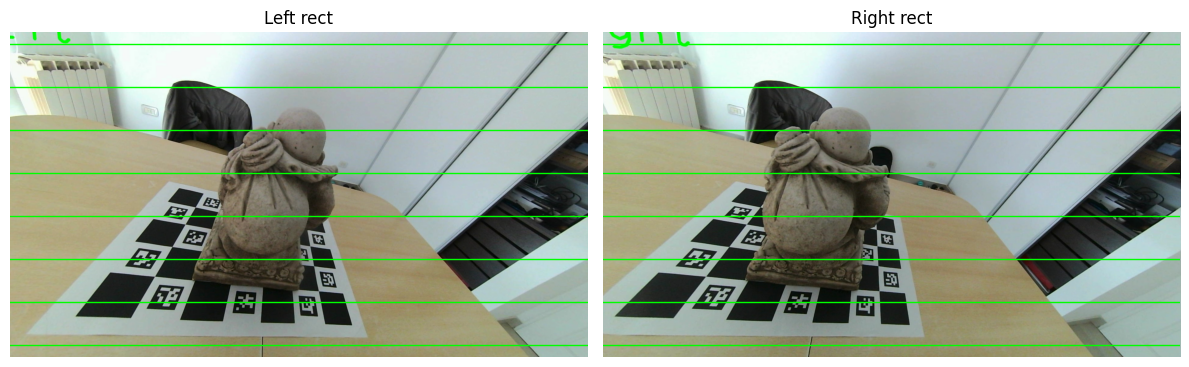

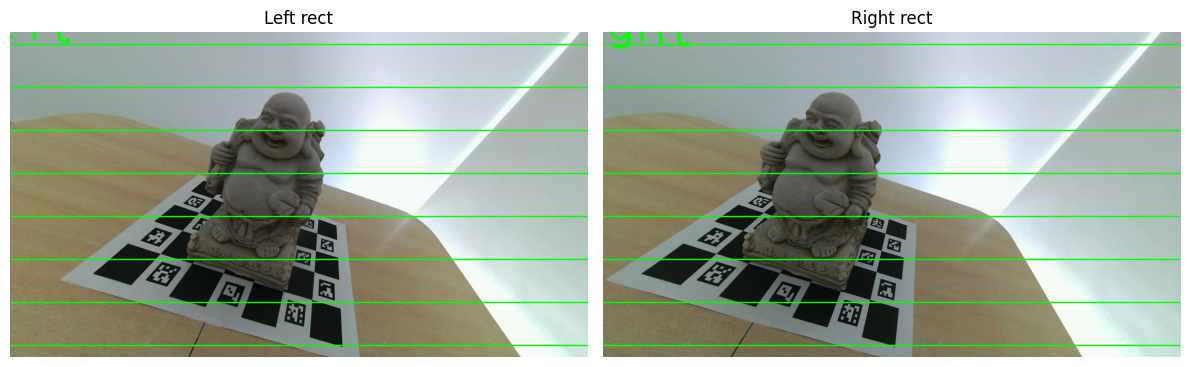

In [4]:
import importlib, rectificacion
importlib.reload(rectificacion)

Q, pares = rectificacion.rectificar_imagenes(
    data_dir="data",
    captures_dir="data/captures",
    out_dir="data/rectified",
    visualizar=True,   # para ver los pares con líneas
    n_muestras=5,
    n_lineas=8
)


In [5]:
# que son Q Y Pares?
print("Matriz Q:\n", Q)
print("\nNúmero de pares rectificados:", len(pares))


Matriz Q:
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -9.66263748e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.24756119e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.04284398e+02]
 [ 0.00000000e+00  0.00000000e+00  1.66693854e-02 -0.00000000e+00]]

Número de pares rectificados: 21


# DISPARIDAD

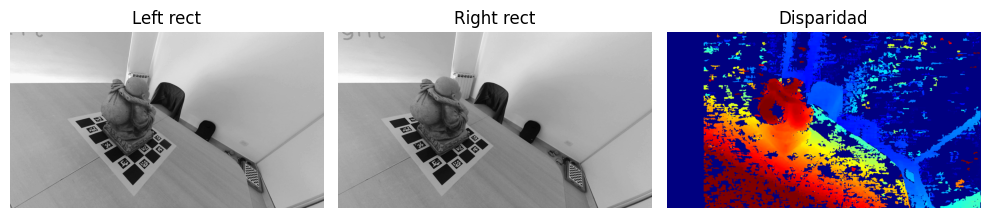

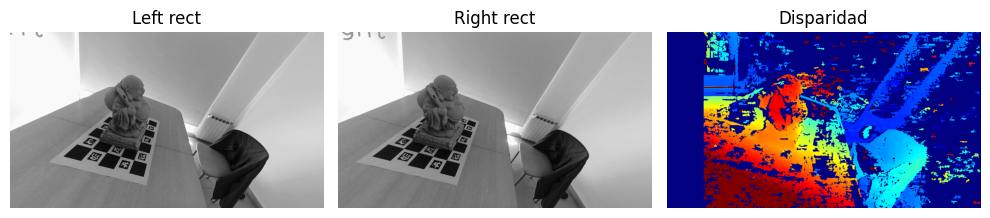

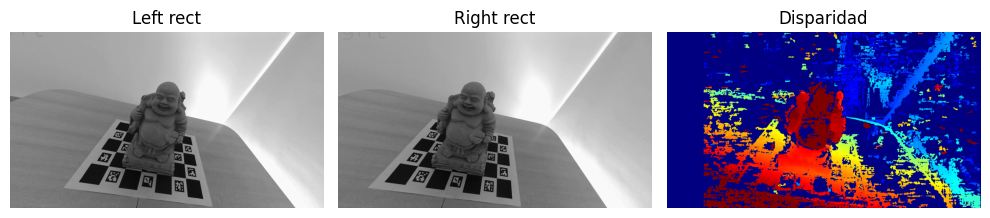

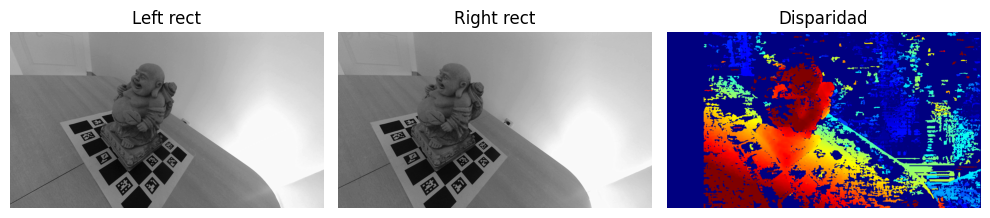

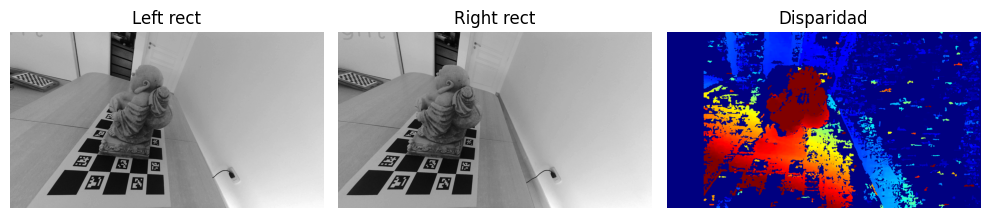

In [6]:
from disparidad import calc_disparidad
calc_disparidad()



# PROFUNDIDAD 

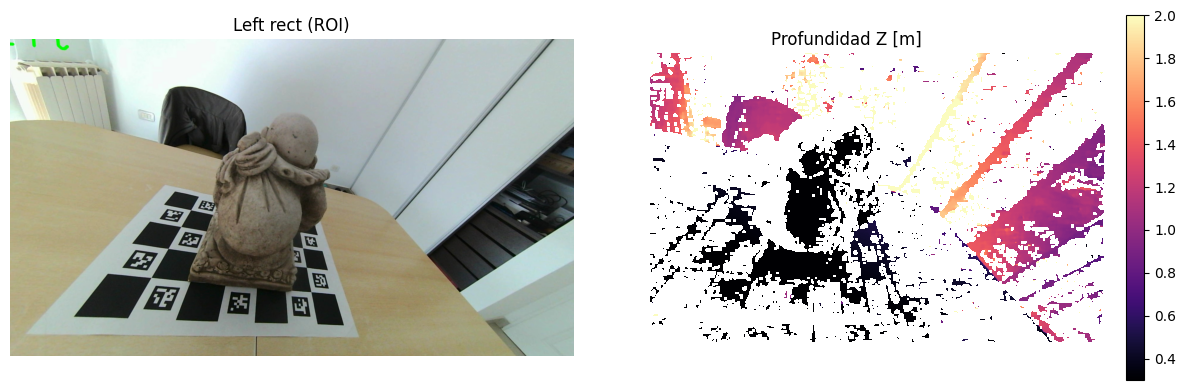

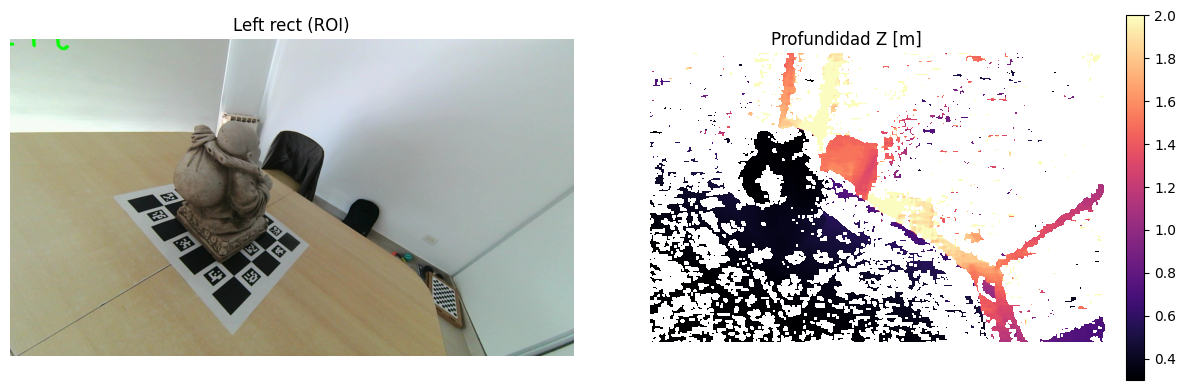

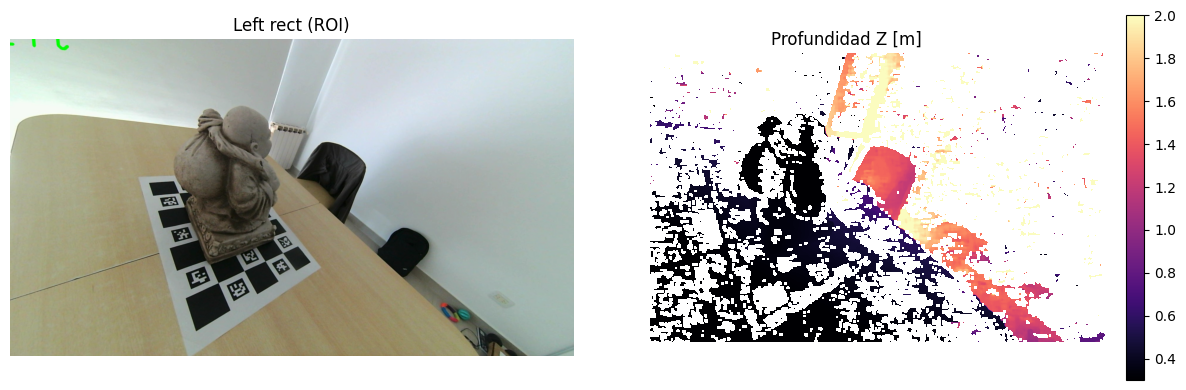

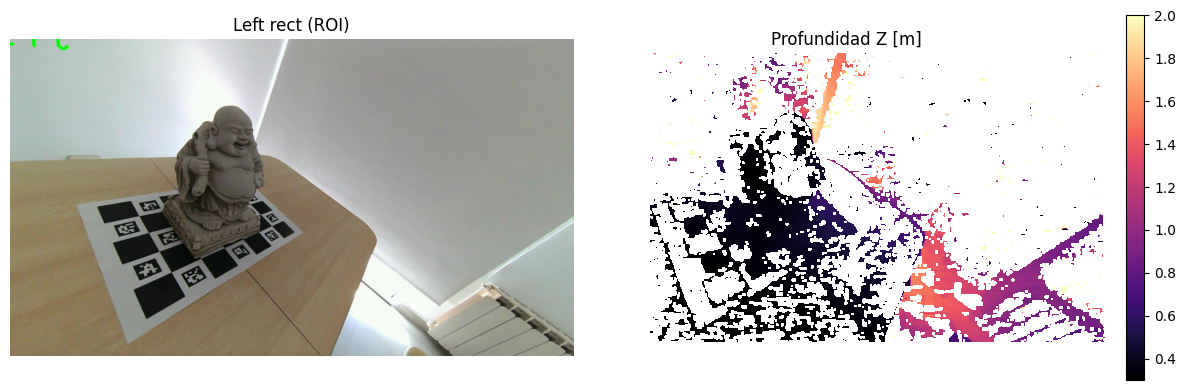

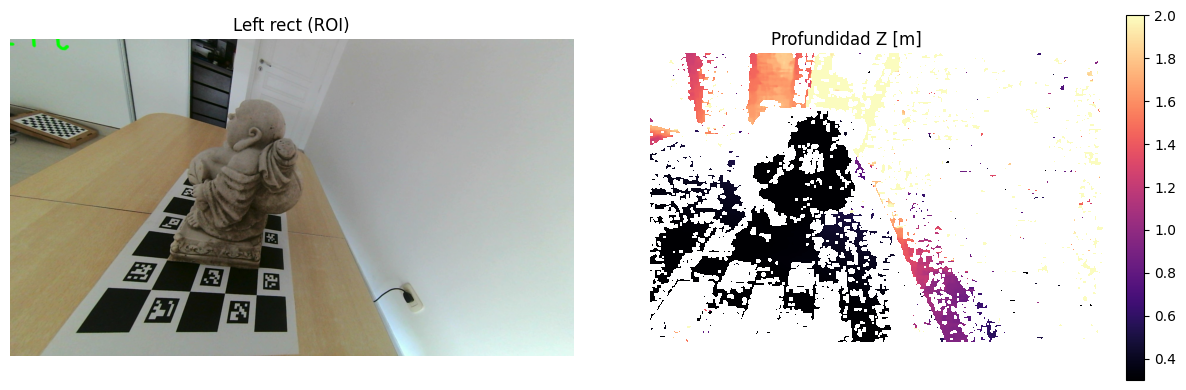

['data/pointcloud/001_left_0_rect.ply',
 'data/pointcloud/002_left_1_rect.ply',
 'data/pointcloud/003_left_10_rect.ply',
 'data/pointcloud/004_left_11_rect.ply',
 'data/pointcloud/005_left_12_rect.ply',
 'data/pointcloud/006_left_13_rect.ply',
 'data/pointcloud/007_left_14_rect.ply',
 'data/pointcloud/008_left_15_rect.ply',
 'data/pointcloud/009_left_16_rect.ply',
 'data/pointcloud/010_left_17_rect.ply',
 'data/pointcloud/011_left_18_rect.ply',
 'data/pointcloud/012_left_19_rect.ply',
 'data/pointcloud/013_left_2_rect.ply',
 'data/pointcloud/014_left_20_rect.ply',
 'data/pointcloud/015_left_3_rect.ply',
 'data/pointcloud/016_left_4_rect.ply',
 'data/pointcloud/017_left_5_rect.ply',
 'data/pointcloud/018_left_6_rect.ply',
 'data/pointcloud/019_left_7_rect.ply',
 'data/pointcloud/020_left_8_rect.ply',
 'data/pointcloud/021_left_9_rect.ply']

In [7]:
import importlib, profundidad
importlib.reload(profundidad)
profundidad.calc_profundidad()


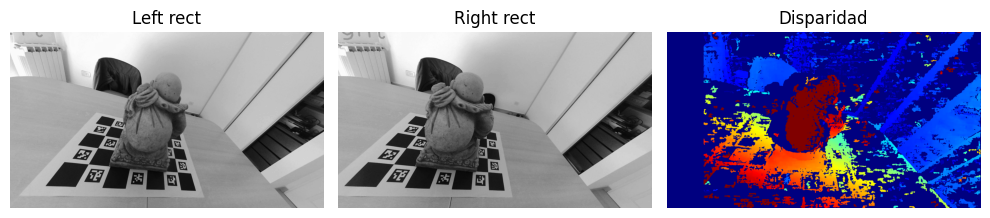

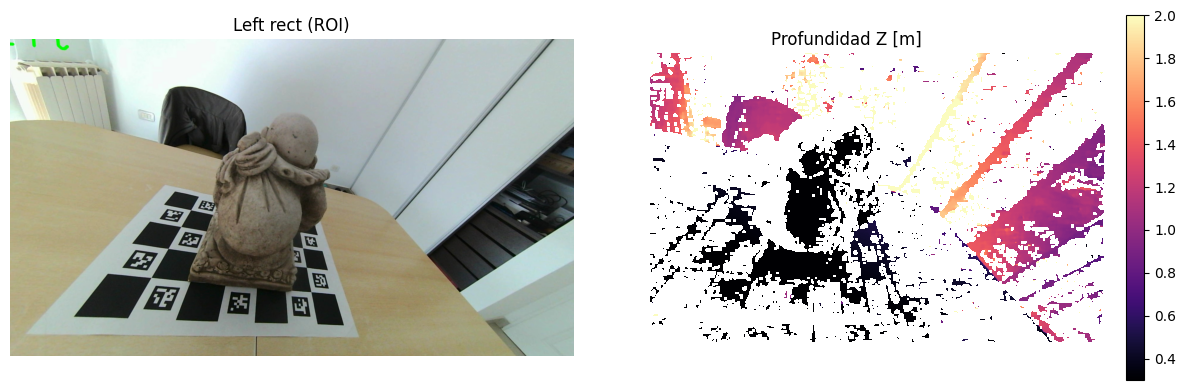

['data/pointcloud/003_left_10_rect.ply']

In [8]:
import  profundidad,disparidad


disparidad.calc_disparidad(name_pattern="left_10")

profundidad.calc_profundidad(name_pattern="left_10")


DETECTAR EL PATRON 

pipeline
Definís un marco de “mundo” usando el patrón (checkerboard o ChArUco).
Detectás sus esquinas 2D en la imagen izquierda rectificada.
Asociás esas esquinas con sus coordenadas 3D reales (en mm).
Corrés cv.solvePnP con K y distorsión de la izquierda → te da rvec, tvec (cámara respecto del mundo definido por el patrón).
Convertís a matriz 4×4 (homogénea) para transformar nubes.

In [9]:
pip install open3d

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ITEM 3 
me pide visualizar los ejes canonicos del marco de coordenadas del mundo en open 3D {[1 0 0], [0 1 0], [0 0 1]}.
visualizar la pose de la camara izquierda en relacion al marco de coordenadas del mundo en open 3D.
parte c :
    usar los ejes del mundo (mostrado en a/b) como referencia;
	2.	con el objeto conocido ( nube reconstruida), crear un bounding box 3D orientado (o3d.geometry.OrientedBoundingBox) para encuadrar ese objeto;
	3.	filtrés la nube para quedarte solo con los puntos dentro de ese bounding box, usando get_point_indices_within_bounding_box(...) → select_by_index(...). 

In [ ]:
import open3d as o3d

## EJ 3.a
world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=0.1,       # escala visual (ajustá según tu escena)
    origin=[0,0,0]  # en el origen del mundo
)

# Mostrar la escena
o3d.visualization.draw_geometries([world_axes], window_name="Ejes del Mundo")



/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [ ]:
# pip install open3d opencv-python numpy
import os, glob
import numpy as np
import cv2 as cv
import open3d as o3d
from detecccion import find_chessboard_robusto

fx = fy = Q[2,3]
cx = -Q[0,3]
cy = -Q[1,3]
K_rect = np.array([[fx, 0, cx],
                   [0, fy, cy],
                   [0,  0,  1]], dtype=float)
dist0 = np.zeros((1,5), dtype=float)  # rectificadas ~ sin distorsión

# ====== Intentar PnP en una izquierda rectificada ======
PATTERN_CANDIDATES = [(9,6), (6,9)]   # probamos ambas orientaciones
SQUARE_SIZE = 0.024                   # m (ajustá al real)


# Buscar una izquierda rectificada
rect_dir = "data/rectified"
candidatas = sorted(glob.glob(os.path.join(rect_dir, "*left*_rect*.png"))) \
          or sorted(glob.glob(os.path.join(rect_dir, "*left*_rect*.jpg"))) \
          or sorted(glob.glob(os.path.join(rect_dir, "*left*_rect*.jpeg")))

T_wc_to_cc = np.eye(4, dtype=float)  # mundo->cámara; identidad por si no hay PnP
img_gray = None

for p in candidatas:
    g = cv.imread(p, cv.IMREAD_GRAYSCALE)
    if g is None:
        continue
    ok, corners, pat = find_chessboard_robusto(g, PATTERN_CANDIDATES)
    if ok:
        cols, rows = pat
        objp = np.zeros((cols*rows, 3), np.float32)
        objp[:, :2] = np.mgrid[0:cols, 0:rows].T.reshape(-1, 2)
        objp *= float(SQUARE_SIZE)

        ret, rvec, tvec = cv.solvePnP(objp, corners, K_rect, dist0, flags=cv.SOLVEPNP_ITERATIVE)
        if ret:
            R,_ = cv.Rodrigues(rvec)
            T_wc_to_cc[:3,:3] = R
            T_wc_to_cc[:3, 3] = tvec.ravel()
            img_gray = g
            print(f"✔️ Pose estimada con {os.path.basename(p)} y patrón {pat}")
            break

if img_gray is None:
    # No hubo tablero: seguimos con identidad para poder visualizar
    # Elegimos un tamaño de imagen “típico” para dibujar el frustum
    img_gray = np.zeros((1080,1920), dtype=np.uint8)
    print("⚠️ No se detectó tablero; se usa pose identidad (cámara en el origen).")

# ====== Visualización: ejes del mundo + frustum posado ======
world_axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0,0,0])

h, w = img_gray.shape[:2]
intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)

cam_lines = o3d.geometry.LineSet.create_camera_visualization(
    view_width_px=w,
    view_height_px=h,
    intrinsic=intrinsic.intrinsic_matrix,
    extrinsic=T_wc_to_cc,   # Open3D espera mundo->cámara
    scale=0.1
)

o3d.visualization.draw_geometries([world_axes, cam_lines],
                                  window_name="Paso 2: Mundo + Pose cámara izquierda")

⚠️ No se detectó tablero; se usa pose identidad (cámara en el origen).
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [4]:
# --- Open3D OBB + filtrado por índices sobre una nube ---
import os, glob
import numpy as np
import open3d as o3d

# 1) Elegí la nube a cargar (puede cambiar el índice)
PLY_DIR = "data/pointcloud"
plys = sorted(glob.glob(os.path.join(PLY_DIR, "*.ply")))
assert plys, f"No hay .ply en {PLY_DIR}"
PLY_PATH = plys[0]  # cambiá a otro índice si querés probar otra nube
print("Usando nube:", os.path.basename(PLY_PATH))

# 2) (Opcional) pose mundo<-cámara: si no la tenés, identidad
T_wc_to_cc = np.eye(4)              # mundo->cámara (no usada aquí)
T_cc_to_wc = np.linalg.inv(T_wc_to_cc)

# 3) Cargar nube (usualmente en marco CÁMARA IZQ rectificada)
pcd_cam = o3d.io.read_point_cloud(PLY_PATH)
assert len(pcd_cam.points) > 0, "La nube está vacía."
# Llevar a marco MUNDO (si T≠I)
pcd_world = pcd_cam.transform(T_cc_to_wc.copy())

# 4) Crear un OBB en el marco MUNDO
#    Opción A: arrancar con un OBB automático como guía
obb_auto = pcd_world.get_oriented_bounding_box()
obb_auto.color = (1, 0, 0)

#    Opción B: definir OBB manual alineado a los ejes del mundo (puede ser lo que pide la cátedra)
center = np.asarray(obb_auto.center)         # podés modificarlo a mano
extent = np.asarray(obb_auto.extent) * 0.6   # más chico para recortar (ajustá)
R_obb  = np.eye(3)                           # alineado a (X,Y,Z) del mundo
obb = o3d.geometry.OrientedBoundingBox(center, R_obb, extent)
obb.color = (0, 0, 1)  # azul para distinguirlo del auto (rojo)

# 5) Filtrar puntos dentro del OBB (punto c de la consigna)
idx = obb.get_point_indices_within_bounding_box(pcd_world.points)
pcd_crop = pcd_world.select_by_index(idx)

# 6) Colorear y visualizar junto con los ejes del mundo
pcd_world.paint_uniform_color([0.7, 0.7, 0.7])  # gris
pcd_crop.paint_uniform_color([0.0, 0.8, 0.0])   # verde
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0,0,0])

o3d.visualization.draw_geometries(
    [axes, pcd_world, obb_auto, obb, pcd_crop],
    window_name="Mundo + OBB (manual y auto) + Nube recortada"
)

print(f"Puntos totales: {len(pcd_world.points)} | dentro del OBB: {len(pcd_crop.points)}")

Usando nube: 001_left_0_rect.ply
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Puntos totales: 719680 | dentro del OBB: 2208
